In [1]:
import xdem
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff, writeTiff


In [2]:
path_tandem = 'data/dem-data/tandem-x/dems_mosaic_wkunlun_utm.tif'     # slave dem
path_aster_dem = 'data/aster-stereo/wkunlun-dems/dems_mosaic_2000.tif' # 


In [3]:
aster_dem, aster_dem_info = readTiff(path_aster_dem)    # master dem
tandem, tandem_info = readTiff(path_tandem)  # slave dem


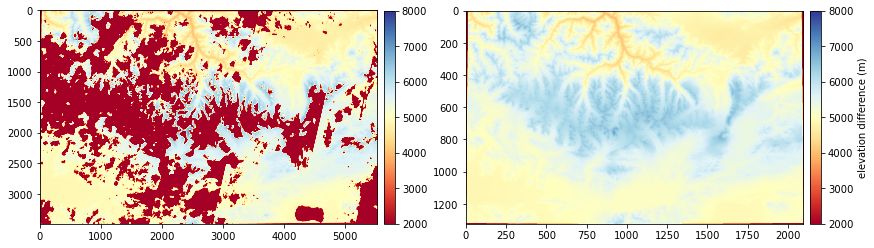

In [4]:
fig1 = plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.imshow(aster_dem, vmin=2000, vmax=8000, cmap='RdYlBu')
cb = plt.colorbar(fraction=0.03, pad=0.02); 
plt.subplot(1,2,2)
plt.imshow(tandem, vmin=2000, vmax=8000, cmap='RdYlBu')
cb = plt.colorbar(fraction=0.03, pad=0.02); 
cb.set_label('elevation difference (m)')
